In [1]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import os
from rasterio.transform import from_origin
import numpy as np

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
gdf = gpd.read_file('final_cleaned_gdf.geojson')

In [3]:
# Use value_counts() to count 1s and 0s in the 'risk' column
risk_counts = gdf['risk'].value_counts()

print("Risk Counts:")
print(risk_counts)

Risk Counts:
risk
0    274652
1       562
Name: count, dtype: int64


In [4]:
# Print CRS information
print("CRS Information:")
print(gdf.crs)

CRS Information:
EPSG:26913


In [5]:
# Check the data type of 'risk' column
print(gdf['risk'].dtype)

# If it's not integer, convert it
if gdf['risk'].dtype != 'int64' and gdf['risk'].dtype != 'int32':
    gdf['risk'] = gdf['risk'].astype(int)
    print("Converted 'risk' column to integer type.")

int32


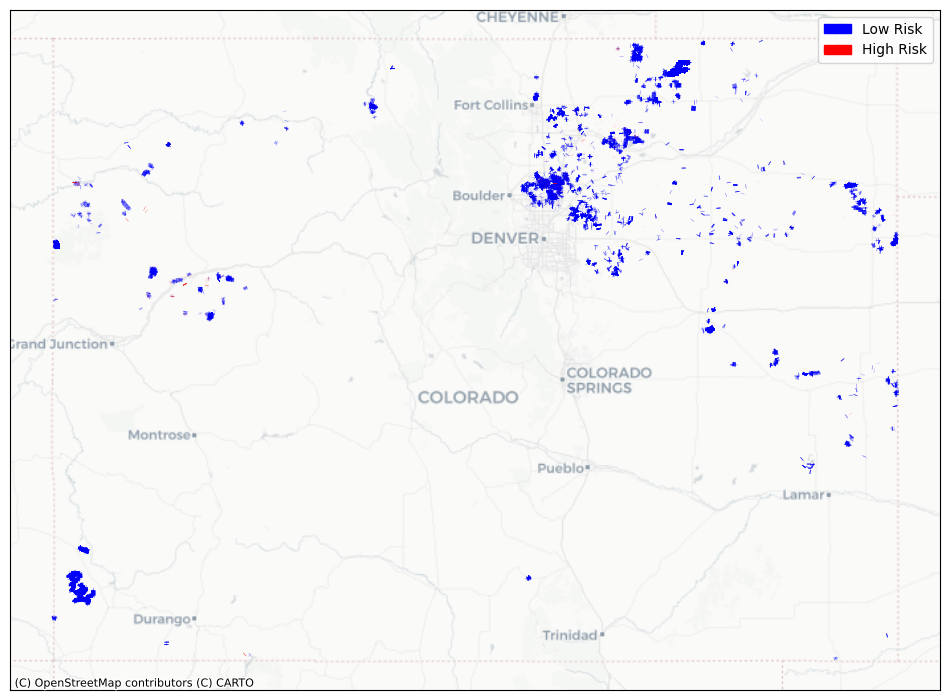

In [11]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


# Convert CRS to EPSG:3857 for contextily base map
gdf_wm = gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
gdf_wm = gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

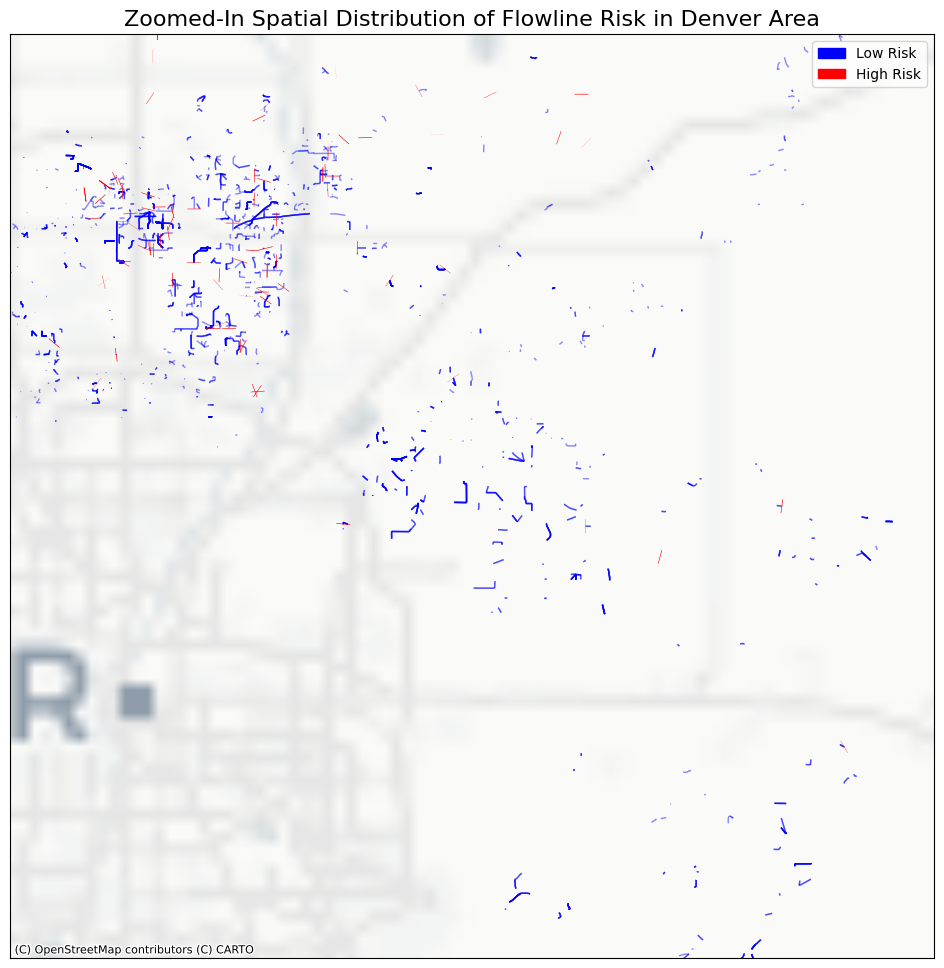

In [10]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Convert CRS to EPSG:3857 for contextily base map
gdf_wm = gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Separate the data by risk level
low_risk = gdf_wm[gdf_wm['risk'] == 0]
high_risk = gdf_wm[gdf_wm['risk'] == 1]

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size

# Plot low-risk geometries (blue) first
low_risk.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)

# Plot high-risk geometries (red) on top with a much larger size
high_risk.plot(ax=ax, color='red', alpha=1.0, linewidth=10)  # Significantly increased line width

# Add a lighter, minimalistic base map to reduce visual clutter
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# Set the plot limits to zoom into the desired area
ax.set_xlim([-11700000, -11600000])
ax.set_ylim([4800000, 4900000])

# Clean up axis
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

# Optional: Add title
ax.set_title('Zoomed-In Spatial Distribution of Flowline Risk in Denver Area', fontsize=16)

# Display the plot
plt.show()

In [3]:
# Define raster resolution
pixel_size = 10  # Adjust as needed

# Calculate bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate number of pixels
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Define transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

In [4]:
output_dir = 'raster_layers'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Corrected Attribute Mappings
status_mapping = {label: idx for idx, label in enumerate(gdf['status'].unique(), start=1)}
gdf['status_code'] = gdf['status'].map(status_mapping)

location_type_mapping = {label: idx for idx, label in enumerate(gdf['location_type'].unique(), start=1)}
gdf['location_type_code'] = gdf['location_type'].map(location_type_mapping)

fluid_mapping = {label: idx for idx, label in enumerate(gdf['fluid'].unique(), start=1)}
gdf['fluid_code'] = gdf['fluid'].map(fluid_mapping)

material_mapping = {label: idx for idx, label in enumerate(gdf['material'].unique(), start=1)}
gdf['material_code'] = gdf['material'].map(material_mapping)

root_cause_mapping = {label: idx for idx, label in enumerate(gdf['root_cause'].unique(), start=1)}
gdf['root_cause_code'] = gdf['root_cause'].map(root_cause_mapping)

In [6]:
# Define raster resolution
pixel_size = 10  # Adjust as needed

# Calculate bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate number of pixels
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Define transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Output directory for individual raster layers
output_dir = 'raster_layers'
os.makedirs(output_dir, exist_ok=True)

attributes = [
    'operator_number',
    'flowline_id',
    'location_id',
    'status_code',        # Encoded categorical
    'location_type_code',# Encoded categorical
    'fluid_code',        # Encoded categorical
    'material_code',     # Encoded categorical
    'diameter_in',
    'length_ft',
    'max_operating_pressure',
    'shape_length',
    'line_age_yr',
    'root_cause_code',   # Encoded categorical
    'risk'               # Target variable
]

for attr in attributes:
    # Define output raster path
    raster_path = os.path.join(output_dir, f"{attr}.tif")
    
    # Handle NaN values by setting a default value, e.g., 0
    gdf_attr = gdf[[attr, 'geometry']].dropna(subset=[attr])
    
    # Prepare shapes as (geometry, value)
    shapes = ((geom, value) for geom, value in zip(gdf_attr.geometry, gdf_attr[attr]))
    
    # Rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Background value
        all_touched=True,
        dtype=rasterio.float32 if gdf[attr].dtype.kind in 'f' else rasterio.int32
    )
    
    # Save raster to file
    with rasterio.open(
        'final_cleaned_raster.tif',
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=gdf.crs,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
    
    print(f"Rasterized {attr} to {raster_path}")

Rasterized operator_number to raster_layers/operator_number.tif
Rasterized flowline_id to raster_layers/flowline_id.tif
Rasterized location_id to raster_layers/location_id.tif
Rasterized status_code to raster_layers/status_code.tif
Rasterized location_type_code to raster_layers/location_type_code.tif
Rasterized fluid_code to raster_layers/fluid_code.tif
Rasterized material_code to raster_layers/material_code.tif
Rasterized diameter_in to raster_layers/diameter_in.tif
Rasterized length_ft to raster_layers/length_ft.tif
Rasterized max_operating_pressure to raster_layers/max_operating_pressure.tif
Rasterized shape_length to raster_layers/shape_length.tif
Rasterized line_age_yr to raster_layers/line_age_yr.tif
Rasterized root_cause_code to raster_layers/root_cause_code.tif
Rasterized risk to raster_layers/risk.tif


In [ ]:
import rasterio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

In [8]:
# Replace 'your_raster.tif' with the path to your raster file
raster_path = 'final_cleaned_raster.tif'

with rasterio.open(raster_path) as src:
    raster_data = src.read()  # Reads all bands
    raster_meta = src.meta
    transform = src.transform


In [9]:
# Replace 'colorado_shapefile.shp' with the path to your Colorado shapefile
colorado_shapefile = 'colorado_shapefile.shp'
colorado = gpd.read_file(colorado_shapefile)


DataSourceError: colorado_shapefile.shp: No such file or directory

In [36]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical

# Directory containing raster layers
raster_dir = 'raster_layers'

# List of raster layer filenames
raster_files = [
    'operator_number.tif',
    'flowline_id.tif',
    'location_id.tif',
    'status_code.tif',
    'location_type_code.tif',
    'fluid_code.tif',
    'material_code.tif',
    'diameter_in.tif',
    'length_ft.tif',
    'max_operating_pressure.tif',
    'shape_length.tif',
    'line_age_yr.tif',
    'root_cause_code.tif',
    'risk.tif'  # Target variable
]

# Full paths
raster_paths = [os.path.join(raster_dir, file) for file in raster_files]

# Initialize list to hold feature arrays
features = []

# Iterate through all raster files except the last one (assuming 'risk.tif' is last)
for path in raster_paths[:-1]:
    with rasterio.open(path) as src:
        data = src.read(1)  # Read the first band
        features.append(data)

# Stack features along the third dimension
X = np.stack(features, axis=-1)  # Shape: (rows, cols, channels)

# Load target variable
with rasterio.open(raster_paths[-1]) as src:
    y = src.read(1)  # Assuming 'risk.tif' is the last file

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

: 

In [ ]:
# Define NoData value (assuming 0 for this example; adjust if different)
nodata_value = 0

# Create a mask where target is not NoData
mask = y != nodata_value

# Apply mask to features and target
X = X[mask]
y = y[mask]

print(f"Filtered Features shape: {X.shape}")
print(f"Filtered Target shape: {y.shape}")

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])  # Reshape for scaling
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # Reshape back

print(f"Number of classes: {num_classes}")


In [ ]:
# Flatten spatial dimensions for splitting
num_samples = X_scaled.shape[0] * X_scaled.shape[1]
X_flat = X_scaled.reshape((num_samples, X_scaled.shape[-1]))
y_flat = y_categorical.reshape((num_samples, num_classes))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

In [ ]:
# Reshape for CNN input
X_train_cnn = X_train.reshape((-1, 1, 1, X_train.shape[-1]))
X_test_cnn = X_test.reshape((-1, 1, 1, X_test.shape[-1]))

print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define input shape
input_shape = (1, 1, X_train_cnn.shape[-1])

# Initialize the model
model = Sequential([
    Conv2D(32, (1,1), activation='relu', input_shape=input_shape),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

In [ ]:
# Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

In [32]:
attributes = [
    'operator_number',
    'flowline_id',
    'location_id',
    'status_code',       # Encoded categorical
    'location_type_code',# Encoded categorical
    'fluid_code',        # Encoded categorical
    'material_code',     # Encoded categorical
    'diameter_in',
    'length_ft',
    'max_operating_pressure',
    'shape_length',
    'line_age_yr',
    'root_cause_code',   # Encoded categorical
    'risk'          
]

for attr in attributes:
    # Define output raster path
    raster_path = os.path.join(output_dir, f"{attr}.tif")
    
    # Handle NaN values by setting a default value, e.g., 0
    gdf_attr = gdf[[attr, 'geometry']].dropna(subset=[attr])
    
    # Prepare shapes as (geometry, value)
    shapes = ((geom, value) for geom, value in zip(gdf_attr.geometry, gdf_attr[attr]))
    
    # Rasterize
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,  # Background value
        all_touched=True,
        dtype=rasterio.float32 if gdf[attr].dtype.kind in 'f' else rasterio.int32
    )
    
    # Save raster to file
    with rasterio.open(
        'final_cleaned_raster.tif',
        'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=gdf.crs,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
    
    print(f"Rasterized {attr} to {raster_path}")

Rasterized operator_number to raster_layers/operator_number.tif
Rasterized flowline_id to raster_layers/flowline_id.tif
Rasterized location_id to raster_layers/location_id.tif
Rasterized status_code to raster_layers/status_code.tif
Rasterized location_type_code to raster_layers/location_type_code.tif
Rasterized fluid_code to raster_layers/fluid_code.tif
Rasterized material_code to raster_layers/material_code.tif
Rasterized diameter_in to raster_layers/diameter_in.tif
Rasterized length_ft to raster_layers/length_ft.tif
Rasterized max_operating_pressure to raster_layers/max_operating_pressure.tif
Rasterized shape_length to raster_layers/shape_length.tif
Rasterized line_age_yr to raster_layers/line_age_yr.tif
Rasterized root_cause_code to raster_layers/root_cause_code.tif
Rasterized risk to raster_layers/risk.tif


In [ ]:
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 1. Define raster layers
raster_dir = 'raster_layers'
raster_files = [
    'operator_number.tif',
    'flowline_id.tif',
    'location_id.tif',
    'status_code.tif',
    'location_type_code.tif',
    'fluid_code.tif',
    'material_code.tif',
    'diameter_in.tif',
    'length_ft.tif',
    'max_operating_pressure.tif',
    'shape_length.tif',
    'line_age_yr.tif',
    'root_cause_code.tif',
    'risk.tif'
]
raster_paths = [os.path.join(raster_dir, file) for file in raster_files]

# 2. Load and stack features
features = []
for path in raster_paths[:-1]:
    with rasterio.open(path) as src:
        data = src.read(1)
        features.append(data)
X = np.stack(features, axis=-1)

# Load target
with rasterio.open(raster_paths[-1]) as src:
    y = src.read(1)

# Mask NoData
mask = y != 0
X = X[mask]
y = y[mask]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

# Normalize features
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)

# Split data
num_samples = X_scaled.shape[0] * X_scaled.shape[1]
X_flat = X_scaled.reshape((num_samples, X_scaled.shape[-1]))
y_flat = y_categorical.reshape((num_samples, num_classes))

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42, stratify=y_encoded
)

# Reshape for CNN
X_train_cnn = X_train.reshape((-1, 1, 1, X_train.shape[-1]))
X_test_cnn = X_test.reshape((-1, 1, 1, X_test.shape[-1]))

# 3. Build CNN model
input_shape = (1, 1, X_train_cnn.shape[-1])

model = Sequential([
    Conv2D(32, (1,1), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(1,1)),
    Dropout(0.2),
    
    Conv2D(64, (1,1), activation='relu'),
    MaxPooling2D(pool_size=(1,1)),
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 4. Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

# 5. Evaluate and predict
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Predict on all data
y_pred = model.predict(X_flat)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reshape to raster
with rasterio.open(raster_paths[-1]) as src:
    profile = src.profile

pred_raster = np.zeros(y.shape, dtype=np.uint8)
pred_raster[mask] = y_pred_classes + 1  # Adjust if classes start at 1

# Save prediction raster
output_path = 'predicted_risk.tif'
profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(pred_raster, 1)

print(f'Prediction raster saved to {output_path}')

# 6. Plot predictions
plt.figure(figsize=(10, 10))
plt.title('Predicted Risk Geospatially')
plt.imshow(pred_raster, cmap='viridis')
plt.colorbar(label='Risk Level')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

In [34]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/26/08/556c4159675c1a30e077ec2a942eeeb81b457cc35c247a5b4a59a1274f05/tensorflow-2.18.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488bb02e58694cd79d61369e85900/flatbuffers-24.3.25-py2.py3-none-any.whl.metadata
  Obtaining dependency information for gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 from https://files.pythonhosted.org/packages/a3/61/8001b38